In [1]:
import pathlib
import random

import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
checkpoint_path = 'training/'
imgroot_path = 'picture/all'
train_path = 'picture/train'
val_path = 'picture/validation'
num_train = 512
num_val = 0
batch_size = 32
epochs = 4
IMG_HEIGHT = 192
IMG_WIDTH = 192

In [4]:
def load_image_label(path, label):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    return image, label

In [5]:
def load_image(path):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    return image

In [6]:
def plot_image(image):
    plt.figure(1)
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [7]:
data_path = pathlib.Path(imgroot_path)
all_image_paths = list(data_path.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if str(path).endswith(".jpg")]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
label_names = sorted(item.name for item in data_path.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

print(image_count)
num_val = image_count - num_train

673


In [8]:
train_image_paths = all_image_paths[:num_train]
val_image_paths = all_image_paths[num_train:]

train_image_labels = all_image_labels[:num_train]
val_image_labels = all_image_labels[num_train:]

In [9]:
train_path_image_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
val_path_image_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_labels))

train_image_label_ds = train_path_image_ds.map(load_image_label)
val_image_label_ds = val_path_image_ds.map(load_image_label)

train_image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [10]:
# print(image_label_ds.take(1))
# (oneimage, onelabel) = image_label_ds.take(1)
# plot_image(oneimage)

# image_label_ds = image_label_ds.apply(
# tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

train_image_label_ds = train_image_label_ds.shuffle(buffer_size=image_count).repeat().batch(batch_size)
train_image_label_ds = train_image_label_ds.prefetch(buffer_size=AUTOTUNE)

val_image_label_ds = val_image_label_ds.shuffle(buffer_size=image_count).repeat().batch(batch_size)
val_image_label_ds = val_image_label_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
def create_model():
    mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
    mobile_net.trainable=False

    model = models.Sequential([
        mobile_net,
        layers.GlobalAveragePooling2D(),
        layers.Dense(16, activation = 'softmax')
        # layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Conv2D(32, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Conv2D(64, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.Dense(16, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 20,496
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model_log = model.fit(train_image_label_ds, 
                      epochs=epochs, 
                      steps_per_epoch=num_train,
                      validation_data=val_image_label_ds,
                      validation_steps=num_val)

Train for 512 steps, validate for 161 steps
Epoch 1/4
512/512 [==============================] - 480s 937ms/step - loss: 0.1104 - accuracy: 0.9791 - val_loss: 0.7865 - val_accuracy: 0.7640
Epoch 2/4
512/512 [==============================] - 473s 924ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.7741 - val_accuracy: 0.7640
Epoch 3/4
512/512 [==============================] - 474s 925ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7690 - val_accuracy: 0.7764
Epoch 4/4
512/512 [==============================] - 471s 921ms/step - loss: 7.2379e-04 - accuracy: 1.0000 - val_loss: 0.7541 - val_accuracy: 0.7826


In [17]:
model.save('dataset_training/model.h5')

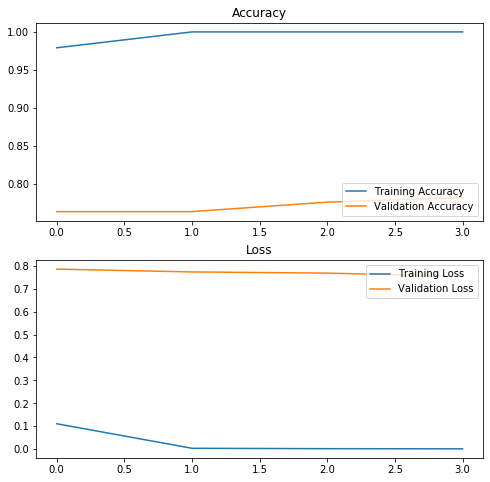

In [19]:
acc = model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.savefig('pic_A&L.jpg')
plt.show()